<a href="https://colab.research.google.com/github/Dimisz/tensorflow_lectures/blob/main/RNN_lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Recurrent Neural Networks** are more effective with sequence data, e.g.
* time-stamped sales data
* sequence of text
* heart beat data
* etc

## RNN Theory
**Sequence** is data that's coming in a specific order, and order is important.

**Normal Neuron workflow**:
Input -> Aggregation of Inputs -> Activation Function -> Output

**Recurrent Neuron workflow**: Input -> Aggregation of Inputs -> Activation Function -> Output -> Aggrregation of Inputs (output is fed to itself)

**Memory Cells** - cells that are a function of inputs from previous time steps.

**RNN Architectures**:
* **Sequence-to-Sequence** (Many to Many): *pass in a sequence and expect a sequence out (e.g. chatbot)*
* **Sequence-to-Vector** (Many to One): *pass in a sequence to predict a single value (generate text: next word)*
* **Vector-to-Sequence** (One to Many)

## Issues with RNNs
Main disadvantage is that RNN only really remember the previous output. It would be useful if we could keep track of longer history, not just short term history.


**1. Vanishing Gradient** as you go back to the 'lower' layers, gradients often get smaller, eventually causing weights to never change at lower layers.

**2. Exploding Gradient** the opposite to 1., gradients 'explode' on the way back, causing issues.

**Solution 1**:
* Using ReLU
* Uning 'Leaky' ReLU
* Exponential Linear Unit (ELU)

**Solution 2**:
* **Batch normalization** - model will normalize each batch using the batch mean and standard deviation.

* **Xavier Initialization** - choosing different initialization of weights

* **Gradient Clipping** (for exploding gradient) - a 'quick fix': gradients are cut off before reaching a predetermined limit (cut off the gradient to be between -1 and 1).

## LSTM (Long Short-Term Memory)

The solutions specified above could slow down training.

After a while the network will begin to 'forget' the first inputs, as information is lost at each step going through RNN.

So we need "long-term" memory.

To address this we have **LSTM(Long Short-Term Memory)**

Structure of LSTM:
* **Forget Gate** - decides what to forget from the previous memory units.
* **Input Gate** - decides what to accept into a neuron.
* **Output Gate** - outputs the new long-term memory. 
* **Update Gate** - updates the memory.


**First step** is to decide what information are we going to throw away/forget from the cell state (pass the weights through sigmoid function: the closer it is to 0, the more are the chances it will be thrown away, the closer it is to 1 - the more chances to keep)

**Second step** is to decide what new information are we going to store to the cell state. 2 parts:

* Input gate layer
* Hyperbolic tangent layer, creating a vector of new candidates.

**Third step** is to update the old cell state: multiply the old state by f(t) forgetting the info we've decided are not important, then we add candidates

**Fourth step** is to decide what we are going to output. So we run a sigmoid layer to decide what parts of the cell state we're going to output. Then we put that cell state through a hyperbolic tangent function which pushes all the values to be between -1 and 1. And than we multiply it by the output of the initial sigmoid gate. 

## Gated Recurrent Unit (GRU)

A variation of LSTM which combines the forget and input gates into 'single update' gate.

## Basic RNN on a Sine Wave

### Preparing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create a sinewave
x = np.linspace(0, 50, 501)

In [3]:
y = np.sin(x)

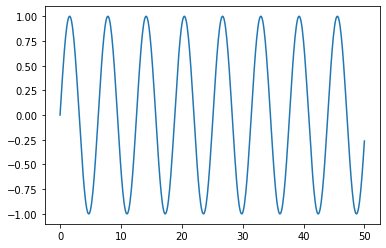

In [4]:
plt.plot(x,y)

In [5]:
df = pd.DataFrame(data=y, index=x, columns=['Sine'])

In [6]:
df

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [7]:
len(df)

501

In [8]:
test_percent = 0.1

In [9]:
test_point = np.round(len(df) * test_percent)

In [10]:
test_point

50.0

In [11]:
test_ind = int(len(df) - test_point)

In [12]:
test_ind

451

In [13]:
train = df.iloc[:test_ind]

In [14]:
test = df.iloc[test_ind:]

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

In [17]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [18]:
scaled_train = scaler.transform(train)

In [19]:
scaled_test = scaler.transform(test)

### Batching

In [20]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
length = 2
batch_size = 1

generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size=batch_size)

In [22]:
len(scaled_train)

451

In [23]:
len(generator) #should be 451 - length(2)

449

### Creating a model

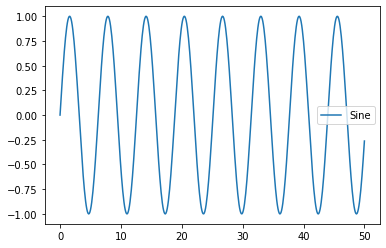

In [24]:
df.plot()

In [25]:
length = 50
batch_size = 1

generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size=batch_size)

In [26]:
from tensorflow.keras.models import Sequential

In [27]:
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

In [28]:
n_features = 1

In [29]:
model = Sequential()
model.add(SimpleRNN(units=50, #equal to length of the batch
                    input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2600      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit_generator(generator, epochs=5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


401/401 [==============================] - 26s 58ms/step - loss: 0.0034
Epoch 2/5
401/401 [==============================] - 23s 58ms/step - loss: 1.6644e-04
Epoch 3/5
401/401 [==============================] - 23s 56ms/step - loss: 1.6259e-04
Epoch 4/5
401/401 [==============================] - 22s 56ms/step - loss: 1.0976e-04
Epoch 5/5
401/401 [==============================] - 23s 56ms/step - loss: 5.0738e-05


In [32]:
losses = pd.DataFrame(model.history.history)

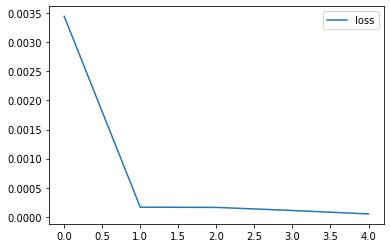

In [33]:
losses.plot()

### Evaluate the model

In [34]:
first_eval_batch = scaled_train[-length:]

In [35]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [36]:
model.predict(first_eval_batch)

array([[0.9461688]], dtype=float32)

In [37]:
scaled_test[0]

array([0.94955134])

### Create logic for predicting multiple points in future

In [38]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

In [39]:
#current_batch

In [40]:
#np.append(current_batch[:, 1:, :], [[[99]]],axis=1)

In [41]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [42]:
#test_predictions

### Inverse predictions (from scaled back to normal)

In [43]:
true_predictions = scaler.inverse_transform(test_predictions)

In [44]:
#true_predictions

In [45]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
#test

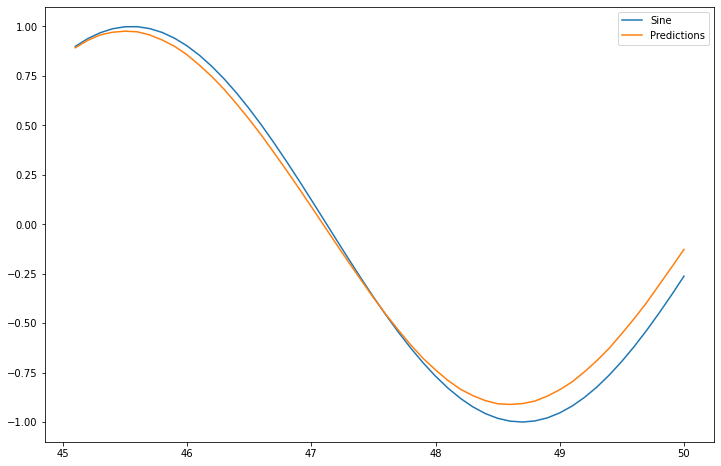

In [47]:
test.plot(figsize=(12,8))

### Using LSTM on Sine Wave

In [48]:
from tensorflow.keras.callbacks import EarlyStopping

In [49]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [50]:
length = 49
generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size=1)

validation_generator = TimeseriesGenerator(scaled_test,
                                           scaled_test,
                                           length=length,
                                           batch_size=1)

In [51]:
model = Sequential()
model.add(LSTM(units=50, #equal to length of the batch
                    input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

In [52]:
model.fit_generator(generator=generator, 
                    validation_data=validation_generator,
                    epochs=20,
                    callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
402/402 [==============================] - 8s 10ms/step - loss: 0.0143 - val_loss: 2.0408e-04
Epoch 2/20
402/402 [==============================] - 3s 9ms/step - loss: 6.7841e-04 - val_loss: 1.1171e-04
Epoch 3/20
402/402 [==============================] - 4s 9ms/step - loss: 4.4958e-04 - val_loss: 9.6256e-06
Epoch 4/20
402/402 [==============================] - 4s 9ms/step - loss: 7.4589e-05 - val_loss: 1.8346e-05
Epoch 5/20
402/402 [==============================] - 4s 9ms/step - loss: 1.0006e-04 - val_loss: 1.4594e-06
Epoch 6/20
402/402 [==============================] - 4s 9ms/step - loss: 1.1655e-04 - val_loss: 1.5347e-06
Epoch 7/20
402/402 [==============================] - 4s 9ms/step - loss: 1.5965e-04 - val_loss: 8.9824e-05


### Evaluate the LSTM model

In [53]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


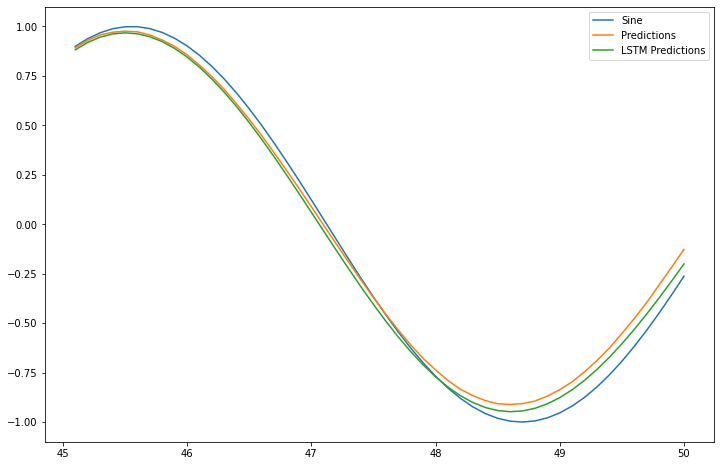

In [54]:
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions
test.plot(figsize=(12,8))

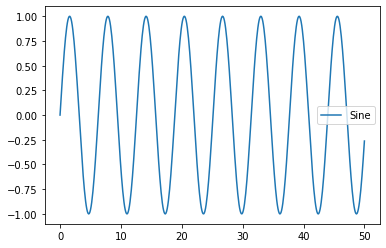

In [55]:
df.plot()

### Making predictions with full data

In [56]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [57]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                                length=length, batch_size=1)

In [58]:
model = Sequential()
model.add(LSTM(units=50, #equal to length of the batch
                    input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

In [59]:
model.fit_generator(generator, epochs=6)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/6
452/452 [==============================] - 6s 9ms/step - loss: 0.0190
Epoch 2/6
452/452 [==============================] - 4s 9ms/step - loss: 3.0003e-04
Epoch 3/6
452/452 [==============================] - 4s 9ms/step - loss: 2.1150e-04
Epoch 4/6
452/452 [==============================] - 4s 9ms/step - loss: 2.6795e-04
Epoch 5/6
452/452 [==============================] - 4s 9ms/step - loss: 3.5887e-04
Epoch 6/6
452/452 [==============================] - 4s 9ms/step - loss: 7.5604e-05


In [60]:
forecast = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(25): # How many points in future
  current_pred = model.predict(current_batch)[0]
  forecast.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [61]:
forecast = scaler.inverse_transform(forecast)

In [62]:
forecast_index = np.arange(50.1, 52.6, step=0.1)

In [63]:
len(forecast_index), len(forecast)

(25, 25)

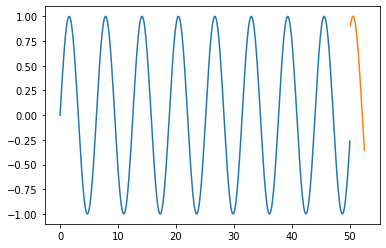

In [64]:
plt.plot(df.index, df['Sine'])
plt.plot(forecast_index, forecast)

## RNN on TimeSeries

### Get Data

In [202]:
!wget "https://raw.githubusercontent.com/Dimisz/tensorflow_lectures/main/RSCCAS.csv"

--2021-10-06 03:39:44--  https://raw.githubusercontent.com/Dimisz/tensorflow_lectures/main/RSCCAS.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6054 (5.9K) [text/plain]
Saving to: ‘RSCCAS.csv.3’

RSCCAS.csv.3        100%[===================>]   5.91K  --.-KB/s    in 0s      

2021-10-06 03:39:44 (62.6 MB/s) - ‘RSCCAS.csv.3’ saved [6054/6054]



In [242]:
df = pd.read_csv("/content/RSCCASN.csv", parse_dates=True, index_col='DATE')

In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [244]:
df.columns = ['Sales']

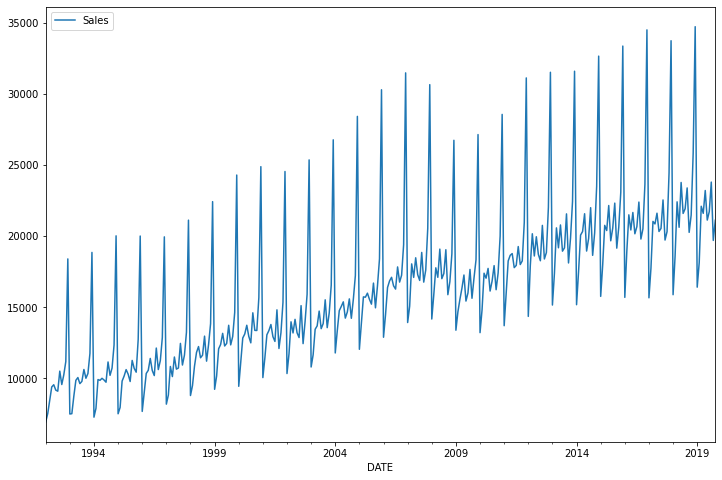

In [245]:
df.plot(figsize=(12,8))


In [246]:
len(df)

334

In [247]:
test_size = 18
test_ind = len(df) - test_size

In [248]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [249]:
from sklearn.preprocessing import MinMaxScaler

In [250]:
scaler = MinMaxScaler()

In [251]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [252]:
scaled_train = scaler.transform(train)

In [253]:
scaled_test = scaler.transform(test)

In [254]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [255]:
len(test)

18

In [256]:
length = 12 #year
generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size=1)

In [257]:
X,y = generator[0]

In [258]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [259]:
y

array([[0.02047633]])

In [260]:
from tensorflow.keras.models import Sequential

In [261]:
from tensorflow.keras.layers import Dense, LSTM

In [262]:
n_features = 1

### Building 1st LSTM model for TimeSeries

In [263]:
ts_model_1 = Sequential()

ts_model_1.add(LSTM(100, activation="relu", input_shape=(length, n_features)))
ts_model_1.add(Dense(1))


ts_model_1.compile(optimizer="adam",
                   loss="mse")

In [264]:
ts_model_1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [265]:
from tensorflow.keras.callbacks import EarlyStopping

In [197]:
early_stop = EarlyStopping(monitor="val_loss", patience=2)

In [266]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                           length=length, batch_size=1)


In [267]:
ts_model_1.fit_generator(generator, epochs=20,
                         validation_data=validation_generator, 
                         callbacks=[early_stop],
                         )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
304/304 [==============================] - 14s 41ms/step - loss: 0.0256 - val_loss: 0.0058
Epoch 2/20
304/304 [==============================] - 12s 40ms/step - loss: 0.0191 - val_loss: 0.0041
Epoch 3/20
304/304 [==============================] - 12s 40ms/step - loss: 0.0125 - val_loss: 0.0042
Epoch 4/20
304/304 [==============================] - 12s 39ms/step - loss: 0.0058 - val_loss: 5.8084e-04
Epoch 5/20
304/304 [==============================] - 12s 40ms/step - loss: 0.0060 - val_loss: 0.0025
Epoch 6/20
304/304 [==============================] - 12s 39ms/step - loss: 0.0028 - val_loss: 2.8897e-04
Epoch 7/20
304/304 [==============================] - 12s 40ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 8/20
304/304 [==============================] - 12s 40ms/step - loss: 0.0013 - val_loss: 5.8104e-04


In [268]:
losses = pd.DataFrame(ts_model_1.history.history)

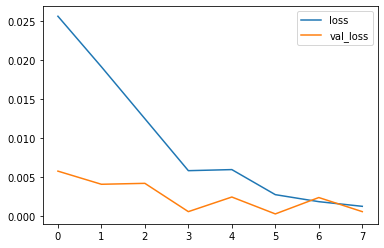

In [269]:
losses.plot()

In [270]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
  #get prediction 1 time stamp ahead
  current_pred = ts_model_1.predict(current_batch)[0]

  # store predictions
  test_predictions.append(current_pred)

  #update batch to now include predictions and drop first value
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [271]:
true_predictions = scaler.inverse_transform(test_predictions)

In [272]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [273]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,21736.556933
2018-06-01,21589,20673.008081
2018-07-01,21919,20928.372496
2018-08-01,23381,22632.540537
2018-09-01,20260,20248.098468
2018-10-01,21473,20851.709322
2018-11-01,25831,24303.088816
2018-12-01,34706,33822.761720
2019-01-01,16410,16234.847981


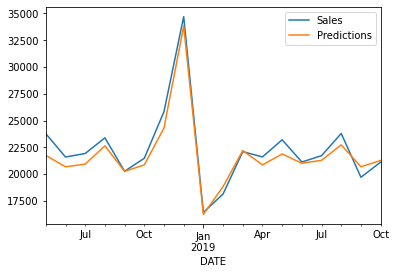

In [274]:
test.plot()